In [27]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


# Feature Selection & Engineering using Statistical Tests

The house prices advanced regression dataset has many features, which makes this dataset great for exploring different feauture selection techniques

There are several problems that arise if your model is running with too many features - you are more likely to overfit th training and validation sets and it will take longer to train and optimize hyperparameters

Data Source/Credit: https://www.kaggle.com/c/house-prices-advanced-regression-techniques

# Overview of Feature Selection Techniques:

1. Filtering: Variance - removes all low variance features based on a given threshold or SelectKBest (Fisher Score (chi-square) for classification, ANOVA F-value (linear relationships) 

2. Wrapper Method: recursive feature elimination
3. Embedded Methods: L1 or L2 regularization

# Univariate Feature Selection

Statistical test like ANOVA or 𝜒2

- Using feature_selection.SelectKBest returns K best features given a scoring function
- Three different scoring functions: 𝜒2, ANOVA F-value, and mutual information score 
- F-value measurs linear dependency, so might underestimate relation between feature and target if relationship is nonlinear
- Mutual information score can capture nonlinear relationships


Data Leakage: It's important to only use the training set for feature selection, otherwise we are introducing a source of potential data leakage

In [28]:
import numpy as np
import pandas as pd 
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
#load data
train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [30]:
train.shape, test.shape

((1460, 81), (1459, 80))

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [32]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [33]:
nulls = train.isnull().sum().sort_values(ascending=False)
nulls_percent = nulls/len(train)
nulls_percent
missing = pd.concat([nulls,nulls_percent],axis=1,keys=['NaN Count','Nan Percent'])
missing = missing[missing['NaN Count'] > 0]
missing

,NaN Count,Nan Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


PoolQC, MiscFeature, Alley and Fence are all missing almost 100% of their values. We already have GarageCars, so we can delete the Garage variables and the remaining as well since they are not essential

In [34]:
train.shape

(1460, 81)

In [35]:
train = train.drop(missing.index,1)
train.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotArea          0
Street           0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 62, dtype: int64

In [36]:
#separat categorical and numerical feature types

categorical = [col for col in train.columns if train.dtypes[col] == 'object']
numerical = [col for col in train.columns if train.dtypes[col] != 'object']

In [37]:
len(categorical)

27

We have 27 categorical variables

In [51]:
len(numerical)

35

We have 35 numerical variables 

In [39]:
train.shape

(1460, 62)

# Normality test and log transformation of target variable

To check normality for our target variable, we can preform a Shapiro-Wilk test(stat.shapiro) test or look at histogram/visualizations 

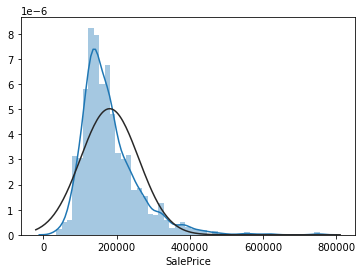

In [40]:
sns.distplot(train.SalePrice, fit=st.norm)

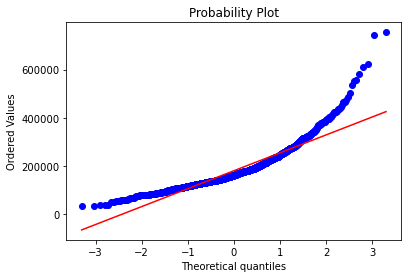

In [41]:
fig = plt.figure()
res = st.probplot(train.SalePrice, plot=plt)
plt.show()

In [42]:
from scipy.stats import shapiro

stat, p = shapiro(train.SalePrice)

print('Statistics=%.3f, p=%.3f' % (stat,p))

alpha=0.5
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

Statistics=0.870, p=0.000
Sample does not look Gaussian (reject H0)


We can confirm that 'SalePrice' does not follow a normal distribution, so it will need to be transformed (log transformation) 

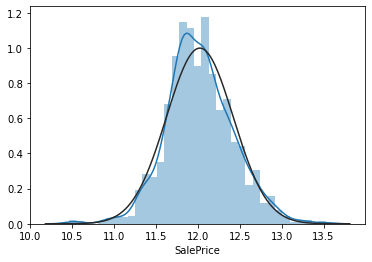

In [43]:
#numerical values need to transformed so they are more normalized 

#applying log transformation; using log1p which applies log(1+x) 

train['SalePrice'] = np.log1p(train.SalePrice)

sns.distplot(train.SalePrice,fit=st.norm)

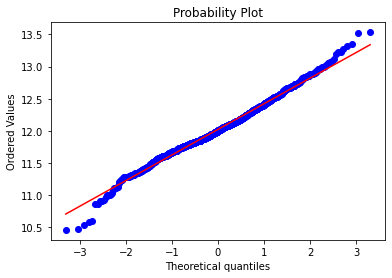

In [44]:
fig = plt.figure()
res = st.probplot(train.SalePrice, plot=plt)
plt.show()

# Scaling and log transformation for numerical features

In [45]:
numerical_feature_cols = train[numerical].columns.drop('SalePrice')

train[numerical_feature_cols] = np.log1p(train[numerical_feature_cols])

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train.loc[:,numerical_feature_cols] = scaler.fit_transform(train.loc[:,numerical_feature_cols])
test.loc[:,numerical_feature_cols] = scaler.transform(test.loc[:,numerical_feature_cols])

# Feature Selection: SelectKBest

**Score function:**

**For regression:** f_regression, mutual_info_regression

**For classification:** chi2, f_classif, mutual_info_regression

f_regression(): Pearson’s Correlation Coefficient (linear), Spearman's rank coefficient (nonlinear). Some statistical measures assume properties of the variables, such as Pearson’s which assumes a Gaussian probability distribution to the observations and a linear relationship. 

# Numerical Features

In [47]:
from sklearn.feature_selection import SelectKBest, f_regression

#Use SelectKBeest objecgt to select 10 features with the best ANOVA F-values 
selector = SelectKBest(f_regression, k=10)

#Feature extraction on training data only
X_new = selector.fit_transform(train[numerical_feature_cols], train['SalePrice'])

selected_features = pd.DataFrame(selector.inverse_transform(X_new),index=train[numerical].index,columns=numerical_feature_cols)

dropped_columns = selected_features.columns[selected_features.var() == 0]

print('The numerical variables SelectKBest is recommending we drop:')
print('')
print(dropped_columns)
dropped_columns.shape

The numerical variables SelectKBest is recommending we drop:

Index(['Id', 'MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'GarageArea', 'WoodDeckSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'],
      dtype='object')


(24,)

In [48]:
new_numerical_cols = train[numerical].drop(dropped_columns, axis=1).columns
print('The 10 best numerical columns SelectKBest has selected:')
print('')
print(new_numerical_cols)


The 10 best numerical columns SelectKBest has selected:

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', '1stFlrSF', 'GrLivArea',
       'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'OpenPorchSF',
       'SalePrice'],
      dtype='object')


# One-way ANOVA test on categorical features against SalePrice

We'll use a one-way ANOVA test to check the correlation between categorical features and SalePrice

One-way ANOVA is used when you have a categorical independent variable (with two or more categories) and a normally distributed dependent variable and you wish to test for differences in the means of the dependent variable broken down by the levels of the independent variable.

Assumptions of ANOVA: normality, homoscedasticity and no multicollinearity

In [49]:
train[categorical].columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'ExterQual', 'ExterCond', 'Foundation', 'Heating',
       'HeatingQC', 'CentralAir', 'KitchenQual', 'Functional', 'PavedDrive',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [50]:
def anova(df):
    anova_results = pd.DataFrame()
    anova_results['Feature'] = categorical 
    pvals =[]
    f_stat = []
    for var in categorical:
        values_list = []
        for i in df[var].unique():
            s =  df[df[var] == i]['SalePrice'].values
            values_list.append(s)
        statistic, pval = st.f_oneway(*values_list)
        pvals.append(pval)
        f_stat.append(statistic)
    anova_results['p_val'] = pvals
    anova_results['f_statistic'] = f_stat
    return anova_results.sort_values('p_val')

a = anova(train)
a

,Feature,p_val,f_statistic
7,Neighborhood,4.041201e-243,79.520526
16,ExterQual,6.930372e-195,415.304259
22,KitchenQual,4.438817e-187,393.320922
18,Foundation,1.350599e-111,126.806779
20,HeatingQC,1.614912e-82,110.820423
0,MSZoning,1.021737e-59,77.607607
14,Exterior1st,1.053089e-53,22.892276
15,Exterior2nd,2.429749e-49,19.922019
21,CentralAir,9.859878e-44,205.666008
26,SaleCondition,1.689524e-41,43.076762


Based in the pvalues, we can see that many of these categorical variables have statistically significant effects on SalePrice

References: 
https://stats.idre.ucla.edu/stata/whatstat/what-statistical-analysis-should-i-usestatistical-analyses-using-stata/
https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
